In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import torchvision
import numpy
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Доступный девайс {i+1}: {torch.cuda.get_device_name(i)}")

Доступный девайс 1: NVIDIA A100-SXM4-80GB
Доступный девайс 2: NVIDIA A100-SXM4-80GB
Доступный девайс 3: NVIDIA A100-SXM4-80GB
Доступный девайс 4: NVIDIA A100-SXM4-80GB
Доступный девайс 5: NVIDIA A100-SXM4-80GB
Доступный девайс 6: NVIDIA A100-SXM4-80GB
Доступный девайс 7: NVIDIA A100-SXM4-80GB
Доступный девайс 8: NVIDIA A100-SXM4-80GB


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Построение изображения в линзе

In [6]:
wavelength = 500.0E-9
N = 1024
length = 10.0E-3
focus = 300.0E-3

spatial_coherence_list = [5000.0E-6, 500.0E-6, 50.0E-6]
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 20

gammas_list = [1.0, 0.5, 2.0]

In [7]:
image = Image.open('../figures/MSU.jpg')
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Grayscale(), torchvision.transforms.Resize((N,N))])
image = transform(image)[0].to(device).to(torch.complex64)

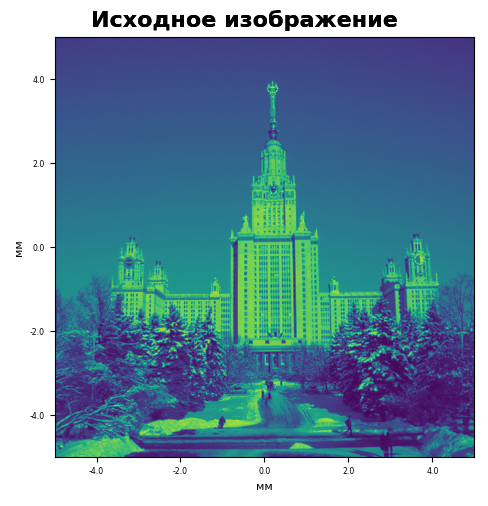

In [8]:
plot = TiledPlot(FigureWidthHeight[0]*0.7, FigureWidthHeight[1]*0.7)
plot.FontLibrary = FontLibrary
plot.title('Исходное изображение')

formatter, unit = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add(0,0)
axes.imshow(image.abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)

plot.save('../figures/LensImage.eps')
plot.show()

In [9]:
lens = Lens(N, length, wavelength, 1.5, 0.0, 1.0, 0.0, focus)

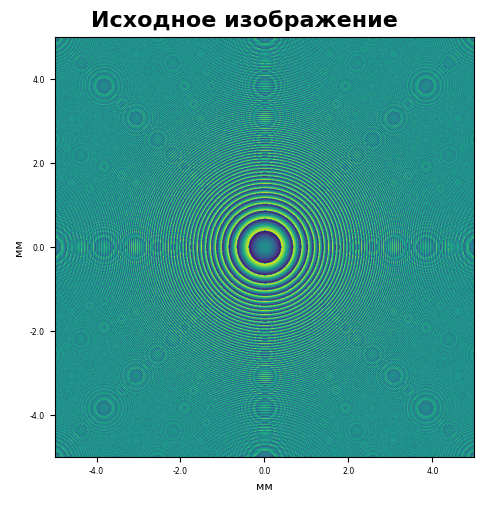

In [10]:
plot = TiledPlot(FigureWidthHeight[0]*0.7, FigureWidthHeight[1]*0.7)
plot.FontLibrary = FontLibrary
plot.title('Исходное изображение')

formatter, unit = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add(0,0)
axes.imshow(lens.mask.angle().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter)
axes.yaxis.set_major_formatter(formatter)
plot.graph.label.x(unit)
plot.graph.label.y(unit)

plot.show()

In [11]:
results_list = []
incoherent_list = []

iterator = iter(tqdm(range(len(spatial_coherence_list)*len(gammas_list))))
next(iterator)
with torch.no_grad():
    for col, spatial_coherence in enumerate(spatial_coherence_list):
        incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)
        incoherent.delayed.launch()
        sample = incoherent.sample()[0].cpu()
        incoherent_list.append(sample)
        for row, gamma in enumerate(gammas_list):            
            a = focus*(1.0/gamma + 1.0)
            b = focus*a / (a - focus)
            propagation1 = FurrierPropagation(N, length, wavelength, 1.0, 0.0, a, 0.5).to(device)
            propagation2 = FurrierPropagation(N, length, wavelength, 1.0, 0.0, b, 0.5).to(device)
            
            optical = CompositeModel(propagation1, lens, propagation2)
            optical.to(device)
            incoherent = Incoherent(length / 20, 0.001, 1.0, 64, N, length)
            optical.wrap(incoherent)
            
            plane = optical.forward(image.view(1,1,N,N)).squeeze().abs().cpu()
            results_list.append(plane)

            try:
                next(iterator)
            except:
                pass

  0%|                                                                                             | 0/9 [00:00<?, ?it/s]

AttributeError: 'Incoherent' object has no attribute 'to'

Exception: Cant find best size for both configurations :(

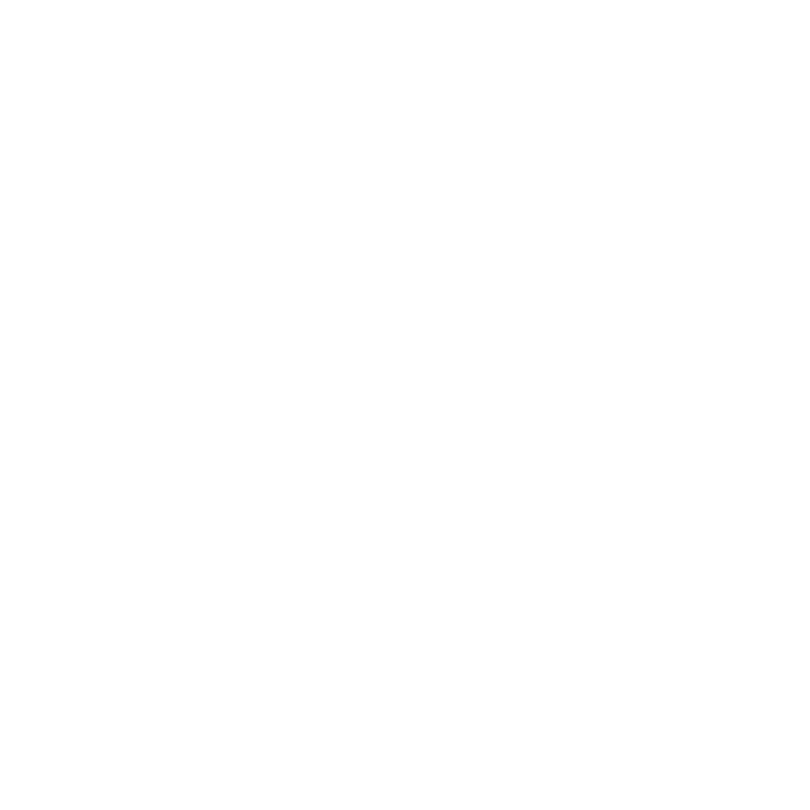

In [12]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Построение изображения в линзе')
# plot.description.top(f"$\\lambda$: {engineering(wavelength,'м',0)}, $d$: {engineering(d,'м',0)}, $b$: {engineering(size,'м',0)}, $L$: {engineering(distance,'м',0)}")
# plot.description.column.top("Экран", 3)
# plot.pad.description.row.left(0.1)
# plot.pad.description.left(0.02)
plot.pad.graph.vertical(0.1)
plot.description.row.left(f"Реализация фазы", 0)
plot.description.top(f"$\\lambda$: {engineering(wavelength,'м',0)}, $f$: {engineering(focus,'м',0)}")


formatter, unit = engineering.separatedformatter(length/2, 'м')

for row, gamma in enumerate(gammas_list, start=1):
    plot.description.row.left(f"γ: {round(gamma, 1)}", row)

index = 0
for col, (sample, spatial_coherence) in enumerate(zip(incoherent_list, spatial_coherence_list)):
    plot.description.column.top(f"$\\sigma$: {engineering(spatial_coherence, 'м', 0, space='')}", col)
    axes = plot.axes.add(col, 0)
    axes.imshow(sample, aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(formatter)
    axes.yaxis.set_major_formatter(formatter)
    plot.graph.label.x(unit)
    plot.graph.label.y(unit)
    for row, gamma in enumerate(gammas_list, start=1):
        result = results_list[index]
        index += 1
        axes = plot.axes.add(col, row)
        axes.imshow(result, aspect='auto', extent=[-length/2,+length/2]*2)
        axes.xaxis.set_major_formatter(formatter)
        axes.yaxis.set_major_formatter(formatter)
        plot.graph.label.x(unit)
        plot.graph.label.y(unit)

#plot.save('../figures/Lenses.eps')
plot.show()